In [3]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import numpy as np

In [126]:
cat_img = Image.open("cat.jpeg")

In [87]:
print("type(img): ", type(cat_img))

type(img):  <class 'PIL.JpegImagePlugin.JpegImageFile'>


In [127]:
b_cat = cat_img.convert("L")

In [89]:
print("size: ", b_cat.size)
print("size: ", cat_img.size)

size:  (1129, 750)
size:  (1129, 750)


In [90]:

img_tensor = torch.Tensor(np.array(cat_img))

In [92]:
ex_img = np.array([[13,1,1,3,4],
                   [12,14,14,2,2],
                   [1,0,16,12,1],
                   [3,3,1,12,11],
                   [2,2,4,1,13]])

In [94]:
ex_img_tensor = torch.Tensor(np.array(b_cat))

In [95]:
kernel = torch.Tensor([[1,0,-1],
                       [1,0,-1],
                       [1,0,-1]])
def convolution(x,kernel):
    print(x.size())
    *_, height, weight = x.size()
    kernel_size = kernel.size(0)
    convs = []
    print(height,kernel_size)
    for i in range(height-kernel_size+1):
        c = [torch.sum(x[i:i+kernel_size,j:j+kernel_size]*kernel) \
             for j in range(weight-kernel_size+1)]
        convs.append(c)
    convs = torch.Tensor(convs)
    return convs

In [96]:
convs = convolution(ex_img_tensor,kernel)
print(np.array(convs))

torch.Size([750, 1129])
750 3
[[-1. -3. -2. ...  0.  0. -1.]
 [-1. -2. -2. ...  0.  0.  0.]
 [-2. -2. -1. ...  0.  0.  1.]
 ...
 [ 0.  0.  0. ...  0.  0. -3.]
 [ 0.  0.  0. ...  0.  0. -3.]
 [ 0.  0.  0. ...  0.  0. -3.]]


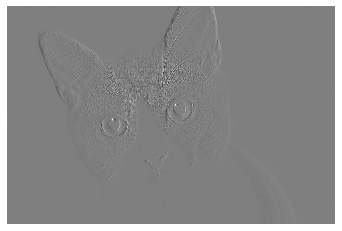

In [97]:
fig, ax = plt.subplots(1,1)
ax.matshow(np.array(convs), cmap="binary")
ax.axis("off")
plt.show()

In [98]:
ver_kernel = torch.Tensor([[1,0,-1],
                       [1,0,-1],
                       [1,0,-1]])
hor_kernel = torch.transpose(ver_kernel,0,1)

In [110]:
battle_ship_img = Image.open("battleship.jpg").convert("L")
battle_ship = torch.Tensor(np.array(battle_ship_img))
ver_convs = convolution(battle_ship,ver_kernel)
hor_convs = convolution(battle_ship,hor_kernel)

torch.Size([800, 628])
800 3
torch.Size([800, 628])
800 3


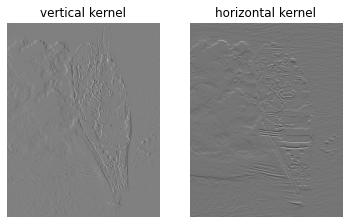

In [111]:
def pltshow(ax, convs, titles):
    ax.imshow(convs.numpy(), cmap="binary")
    ax.axis("off")
    ax.set_title(titles)
fig,(ax1,ax2)= plt.subplots(1,2)
pltshow(ax1,ver_convs,"vertical kernel")
pltshow(ax2,hor_convs,"horizontal kernel")
plt.show()

In [154]:
img_tensor = torch.Tensor(np.array(b_cat)).expand(1,1,750,1129)
batch, in_channels, height, weight = img_tensor.size()
img_tensor.size()

torch.Size([1, 1, 750, 1129])

In [157]:
out_channels = 1
kernel_size = 3
stride = 1

In [162]:
con_layer = nn.Conv2d(in_channels = in_channels,
                      out_channels = out_channels,
                      kernel_size = kernel_size,
                      stride = stride)


In [177]:
def pooling(x,kernel_size, stride=None):
    if stride is None:
        stride = kernel_size
    b,c,height,weight = x.size()
    maxpool = x.unfold(2,kernel_size,stride).unfold(3,kernel_size,stride).max(-1)[0].max(-1)[0]
    return maxpool

In [190]:
activation_maps = torch.relu(convs)
con_layer.weight_data = ver_kernel.expand(1,1,kernel_size,kernel_size)
convs = con_layer(img_tensor)

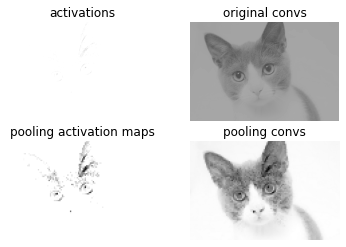

In [205]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
pltshow(ax1,activation_maps.squeeze().detach(),"activations")
pltshow(ax2,convs.squeeze().detach(),"original convs")
pltshow(ax3,pooling(activation_maps,10).squeeze().detach(),"pooling activation maps")
pltshow(ax4,pooling(convs,10).squeeze().detach(),"pooling convs")
plt.show()

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = lambda x: x.view(x.size(0),-1)
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=8,
                               kernel_size=5,
                               stride=1,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=8,
                               out_channels=16,
                               kernel_size=2,
                               stride=1,
                               padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc = nn.Linear(784,10)
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.pool(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.pool(x)
        x=self.flatten(x)
        x=self.fc(x)
        return x

In [7]:
torch.manual_seed(70)
model = CNN().to("cpu")

In [9]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())